In [1]:
import tone
import utils
from utils import *

tone.utils.ipython.autoreload(utils)
tone.utils.learning.ignore_warning()
device = tone.utils.learning.try_use_device()
device

device(type='cuda')

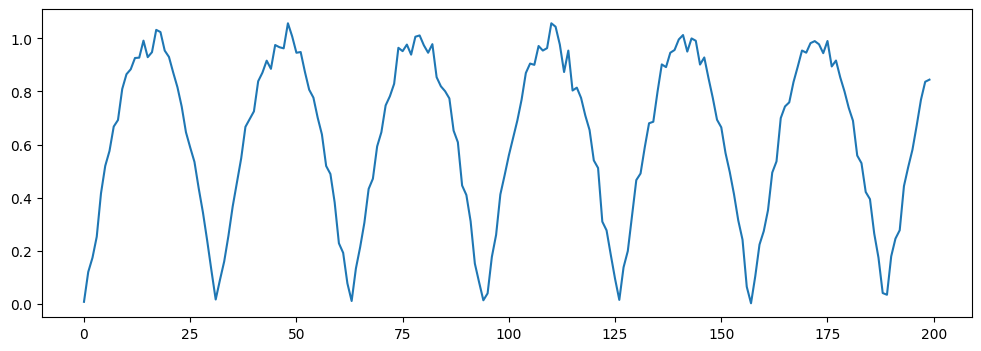

In [2]:
def sine_dataset(count=10000):
    x = np.linspace(0, 1000, count)
    y = np.abs(np.sin(x) + np.random.randn(x.shape[0]) * 0.03)
    return y


data = sine_dataset()

fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(data[:200])
plt.show()

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0.01, 0.99))
data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)
print(data, data.min(), data.max())

[0.01706695 0.11778679 0.16584175 ... 0.60766352 0.67518307 0.73192717] 0.01 0.99


In [4]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, data, lags) -> None:
        super().__init__()

        self.lags = lags
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return (self.data.numel() - self.lags - 1)

    def __getitem__(self, index):
        return (
            self.data[index: self.lags + index],
            self.data[self.lags + index],
        )

lags = 12
dataset = TimeSeriesDataset(data, lags)
dataset[0]

(tensor([0.0171, 0.1178, 0.1658, 0.2366, 0.3827, 0.4755, 0.5257, 0.6081, 0.6302,
         0.7349, 0.7846, 0.8013]),
 tensor(0.8393))

In [5]:
class Model(nn.Module):

    def forward(self, x: torch.Tensor):
        y = self.model(x)
        return y.reshape(-1)

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
            nn.LazyLinear(128),
            nn.LazyBatchNorm1d(),
            nn.Sigmoid(),

            nn.LazyLinear(32),
            nn.LazyBatchNorm1d(),
            nn.Sigmoid(),

            nn.LazyLinear(1),
            nn.Sigmoid()
        )

lags = 12
batch_size = 2

dataloader = torch.utils.data.DataLoader(
    dataset=TimeSeriesDataset(data, lags),
    batch_size=batch_size,
    drop_last=True,
    generator=torch.Generator(device=device),
    shuffle=True,
)
model = Model()
for x, t in dataloader:
    y = model(x)
    print(y)
    break


tensor([0.3181, 0.3127], grad_fn=<ReshapeAliasBackward0>)


In [6]:

lags = 12
batch_size = 256
epoch = 20

model = Model()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

losses = utils.fit(
    model=model,
    dataset=TimeSeriesDataset(data, lags),
    criterion=criterion,
    optimizer=optimizer,
    epoch=epoch,
    batch_size=batch_size,
    device=device,
    shuffle=True,
    progress=True,
    step_callback=None,
)


(20/20) | (39/39): 100%|██████████| 780/780 [00:03<00:00, 218.33it/s, loss=0.00115113] 


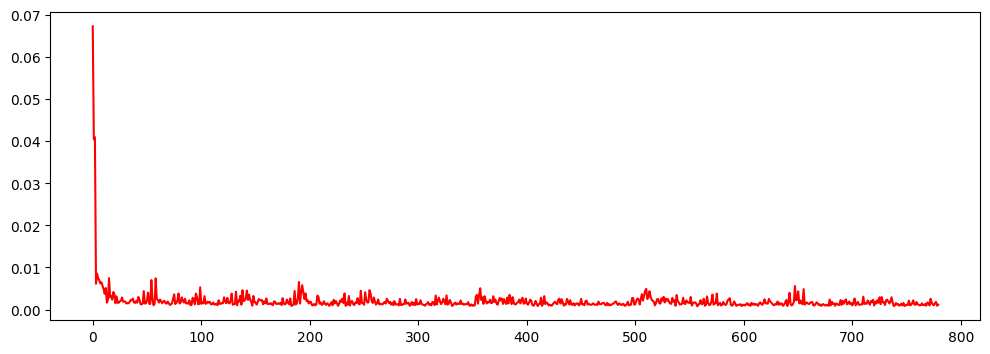

In [7]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(losses, 'r')
plt.show()
plt.close()

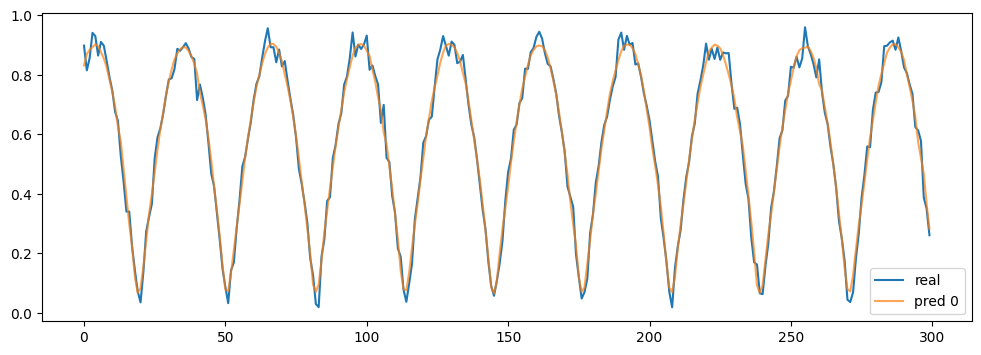

In [8]:
testset = sine_dataset()
scaler = MinMaxScaler(feature_range=(0.01, 0.99))
testset = scaler.fit_transform(testset.reshape(-1, 1)).reshape(-1)
dataset = TimeSeriesDataset(testset, lags=lags)

model.eval()
real, preds = utils.test([model], dataset, batch_size, device, progress=False)


fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(real.detach().cpu()[:300], label='real')
for i, pred in enumerate(preds):
    ax.plot(pred.detach().cpu()[:300], alpha=0.7, label=f'pred {i}')

plt.legend()
plt.show()
plt.close()
